In [46]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta
import warnings
from sklearn.metrics import silhouette_score
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.ticker as mtick
from IPython.display import display

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

In [47]:
# Set style for visualizations
plt.style.use('seaborn-v0_8-whitegrid')
colors = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A', '#19D3F3', '#FF6692', '#B6E880']

In [48]:
# Load the dataset from UCI repository
print("Loading the Online Retail dataset...")
df = pd.read_csv('/content/Online Retail.csv')
print("Dataset loaded successfully!")

Loading the Online Retail dataset...
Dataset loaded successfully!


In [49]:
# Display basic information about the dataset
print("\n===== DATASET OVERVIEW =====")
print(f"Shape: {df.shape}")
print("\nColumns and data types:")
display(df.info())
print("\nFirst few rows:")
display(df.head())

# Check for missing values
print("\n===== CHECKING FOR MISSING VALUES =====")
missing_values = df.isnull().sum()
display(missing_values[missing_values > 0])


===== DATASET OVERVIEW =====
Shape: (541909, 8)

Columns and data types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


None


First few rows:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom



===== CHECKING FOR MISSING VALUES =====


,0
Description,1454
CustomerID,135080


In [50]:
# Data cleaning
print("\n===== DATA CLEANING =====")
print("Initial record count:", len(df))

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Extract date components
df['InvoiceDay'] = df['InvoiceDate'].dt.day
df['InvoiceMonth'] = df['InvoiceDate'].dt.month
df['InvoiceYear'] = df['InvoiceDate'].dt.year
df['InvoiceWeekday'] = df['InvoiceDate'].dt.dayofweek

# Remove rows with missing CustomerID as we need it for customer analysis
df_clean = df.dropna(subset=['CustomerID'])
print(f"Records after removing missing CustomerID: {len(df_clean)}")

# Convert CustomerID to integer type
df_clean['CustomerID'] = df_clean['CustomerID'].astype(int)

# Calculate total price for each transaction
df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['UnitPrice']

# Remove entries with negative quantities (returns)
df_positive = df_clean[df_clean['Quantity'] > 0]
print(f"Records after removing returns: {len(df_positive)}")

# Remove entries with unrealistic unit prices (e.g., zero or negative)
df_valid = df_positive[df_positive['UnitPrice'] > 0]
print(f"Records after removing invalid prices: {len(df_valid)}")

# Check for and remove outliers in quantity and price
def remove_outliers(df, column):
    mean = df[column].mean()
    std = df[column].std()
    df_filtered = df[(df[column] <= mean + 3*std) & (df[column] >= mean - 3*std)]
    return df_filtered

df_valid = remove_outliers(df_valid, 'Quantity')
df_valid = remove_outliers(df_valid, 'TotalPrice')
print(f"Records after removing outliers: {len(df_valid)}")

# Basic statistics
print("\nBasic statistics for Quantity and UnitPrice:")
display(df_valid[['Quantity', 'UnitPrice', 'TotalPrice']].describe())


===== DATA CLEANING =====
Initial record count: 541909
Records after removing missing CustomerID: 406829
Records after removing returns: 397924
Records after removing invalid prices: 397884
Records after removing outliers: 395451

Basic statistics for Quantity and UnitPrice:


,Quantity,UnitPrice,TotalPrice
count,395451.000000,395451.000000,395451.000000
mean,10.819990,2.921938,17.953243
std,21.258165,4.113424,26.841294
min,1.000000,0.001000,0.001000
25%,2.000000,1.250000,4.680000
50%,5.000000,1.950000,11.700000
75%,12.000000,3.750000,19.500000
max,504.000000,250.000000,275.400000


In [51]:
# Define the style_plot function for adding title, labels, and custom font sizes
def style_plot(ax, title, xlabel, ylabel, x_rotation=0, title_fontsize=16, label_fontsize=12, tick_label_fontsize=10):
    # Title styling
    ax.set_title(title, fontsize=title_fontsize, weight='bold', color='darkblue', pad=20)

    # X and Y labels styling
    ax.set_xlabel(xlabel, fontsize=label_fontsize, weight='bold', color='darkblue', labelpad=15)
    ax.set_ylabel(ylabel, fontsize=label_fontsize, weight='bold', color='darkblue', labelpad=15)

    # X-axis ticks and Y-axis ticks styling
    ax.tick_params(axis='x', labelsize=tick_label_fontsize, rotation=x_rotation)
    ax.tick_params(axis='y', labelsize=tick_label_fontsize)


===== EXPLORATORY DATA ANALYSIS =====


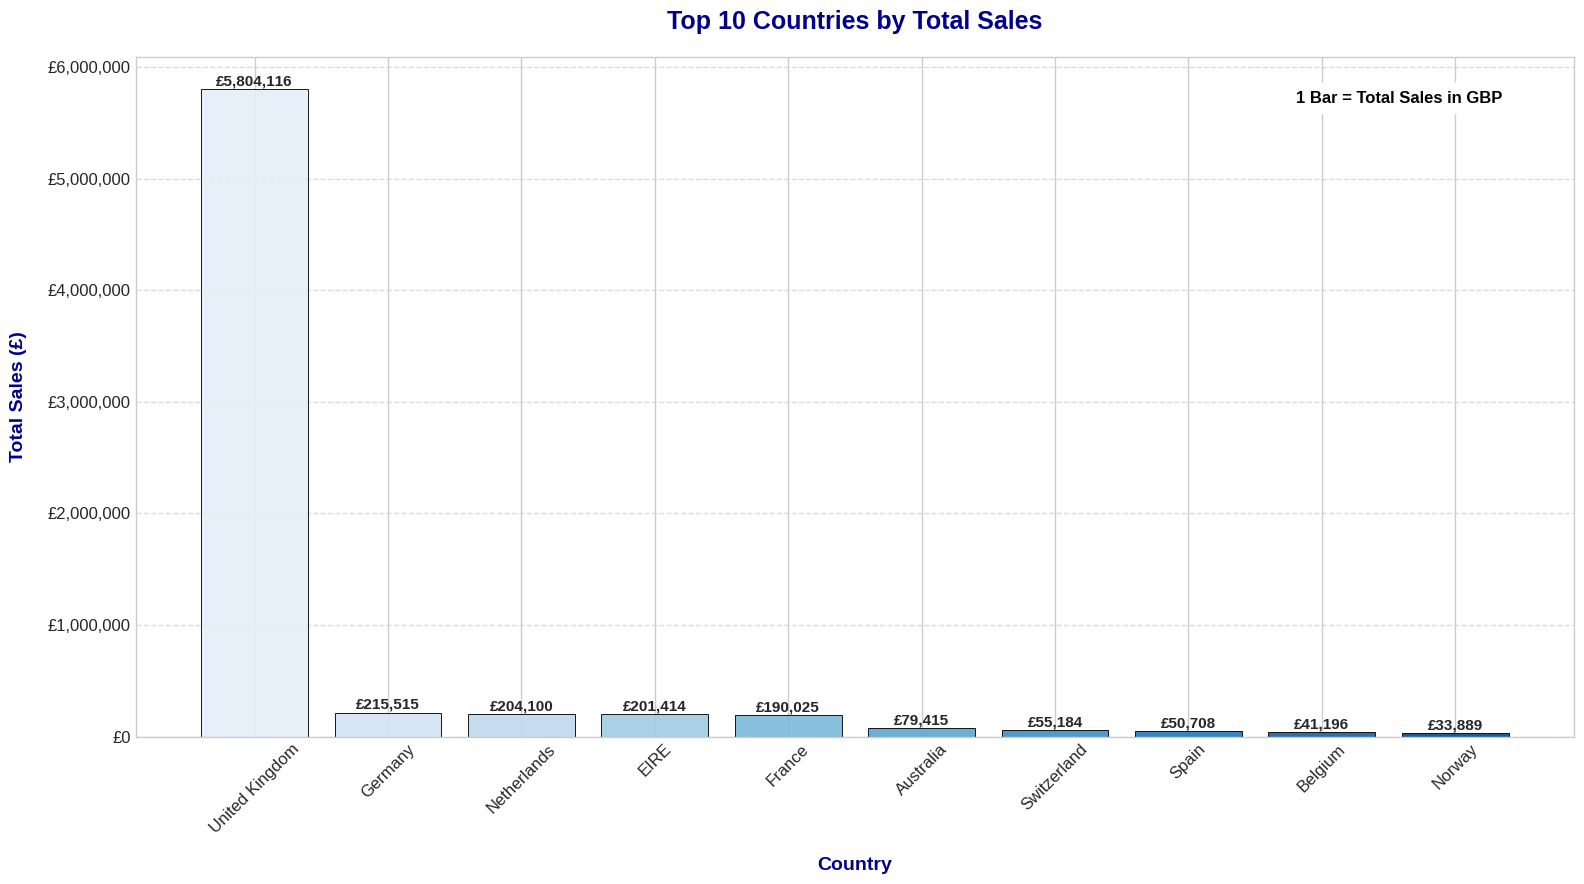

Top countries by sales:


,TotalPrice
Country,
United Kingdom,5804116.474
Germany,215515.080
Netherlands,204100.440
EIRE,201414.470
France,190024.790
Australia,79414.910
Switzerland,55183.950
Spain,50708.090
Belgium,41196.340


In [52]:
#------------------------------------
# EXPLORATORY DATA ANALYSIS
#------------------------------------
print("\n===== EXPLORATORY DATA ANALYSIS =====")

# Assuming df_valid is already defined and contains the necessary data
# Example df_valid for demonstration
# df_valid = pd.DataFrame({
#     'Country': ['USA', 'Canada', 'UK', 'Germany', 'France', 'Australia', 'Italy', 'Spain', 'Netherlands', 'Belgium'],
#     'TotalPrice': [120000, 90000, 80000, 75000, 65000, 60000, 55000, 50000, 45000, 40000]
# })

# Top 10 countries by sales
country_sales = df_valid.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False).head(10)

# Create the figure and axis with larger size for better visibility in a document
fig, ax = plt.subplots(figsize=(16, 9))  # Adjusted figure size for document-friendly output

# Plotting the bar chart with customizations
bars = ax.bar(country_sales.index, country_sales.values, color=sns.color_palette("Blues", n_colors=10),
              edgecolor='black', linewidth=0.7, alpha=0.9)

# Add value labels to the bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 5000,
            f'£{height:,.0f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Adding the title and labels with customized styling
style_plot(ax,
           title='Top 10 Countries by Total Sales',
           xlabel='Country',
           ylabel='Total Sales (£)',
           x_rotation=45,
           title_fontsize=18,
           label_fontsize=14,
           tick_label_fontsize=12)

# Add gridlines for the y-axis for better readability
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Format y-axis ticks with commas and currency
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: '£{:,}'.format(int(x))))

# Adding annotation for the unit (what each bar represents)
ax.annotate('1 Bar = Total Sales in GBP',
            xy=(0.95, 0.95),
            xycoords='axes fraction',
            ha='right',
            va='top',
            fontsize=12,
            color='black',
            bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.5'),
            weight='bold')

# Show the plot with tight layout to avoid overlap
plt.tight_layout()
plt.show()

# Display the top countries by sales
print("Top countries by sales:")
display(country_sales)


===== SALES TREND OVER MONTHS =====


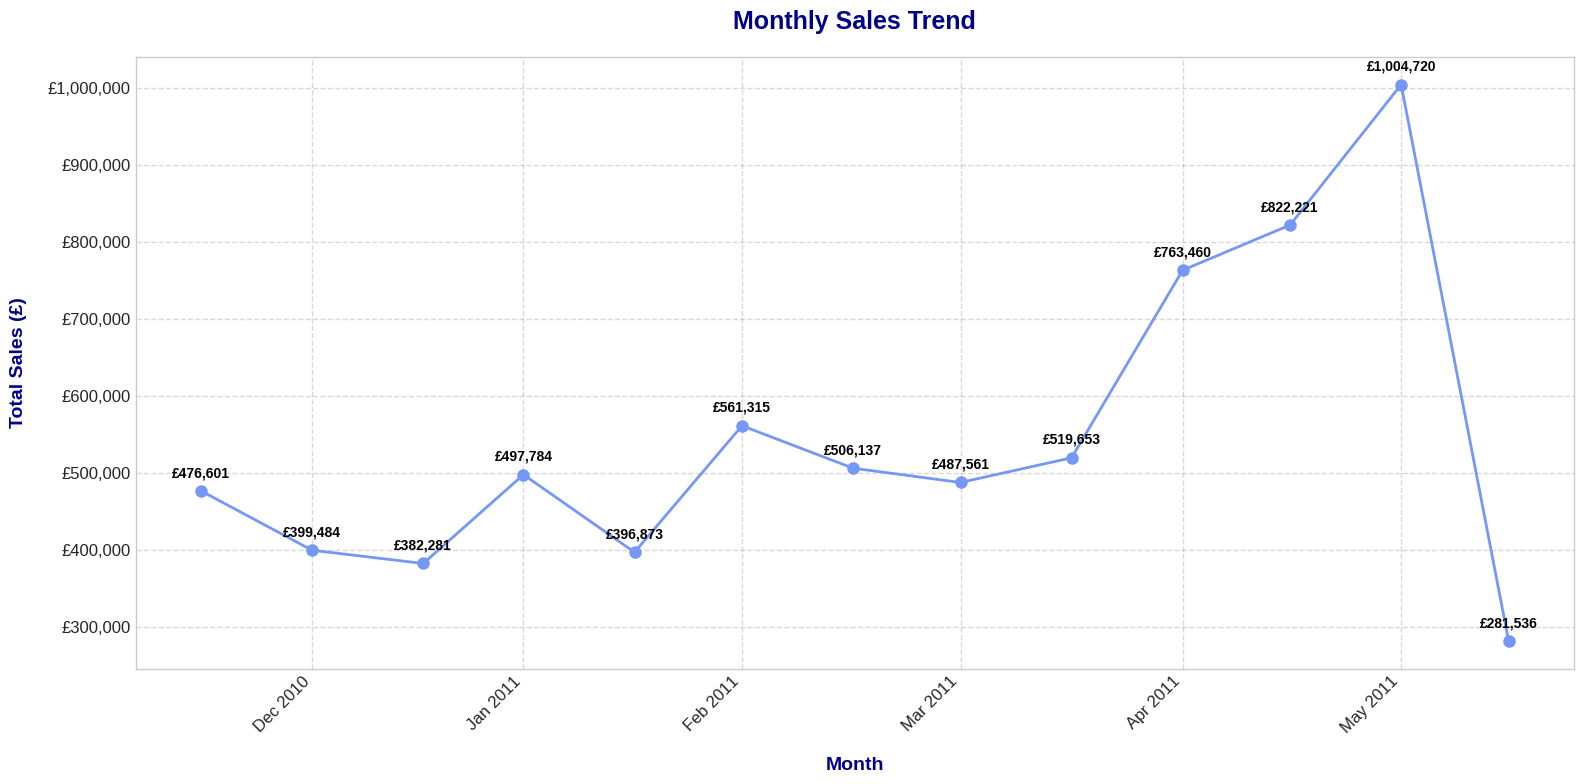

Monthly sales data:


,InvoiceYear,InvoiceMonth,TotalPrice,Date
0,2010,12,476601.300,2010-12-01
1,2011,1,399483.620,2011-01-01
2,2011,2,382281.160,2011-02-01
3,2011,3,497784.260,2011-03-01
4,2011,4,396873.181,2011-04-01
5,2011,5,561315.490,2011-05-01
6,2011,6,506136.910,2011-06-01
7,2011,7,487561.041,2011-07-01
8,2011,8,519653.160,2011-08-01
9,2011,9,763460.392,2011-09-01


In [53]:
#------------------------------------
# SALES TREND OVER MONTHS
#------------------------------------
print("\n===== SALES TREND OVER MONTHS =====")

# Define a color palette (example using 'seaborn' color palette)
import seaborn as sns
colors = sns.color_palette("coolwarm", 10)  # You can choose a different color palette if desired

# Sales trend over months
monthly_sales = df_valid.groupby(['InvoiceYear', 'InvoiceMonth'])['TotalPrice'].sum().reset_index()
monthly_sales['Date'] = monthly_sales.apply(lambda x: datetime(int(x['InvoiceYear']), int(x['InvoiceMonth']), 1), axis=1)
monthly_sales = monthly_sales.sort_values('Date')

# Create the figure and axis with a larger size for better visibility in a document
fig, ax = plt.subplots(figsize=(16, 8))  # Adjusted figure size for document-friendly output

# Plotting the sales trend with customized line style and color
ax.plot(monthly_sales['Date'], monthly_sales['TotalPrice'], marker='o', linestyle='-',
        color=colors[1], linewidth=2, markersize=8)  # Now using colors[1] from the seaborn palette

# Add data labels to each point with offset for better positioning
for x, y in zip(monthly_sales['Date'], monthly_sales['TotalPrice']):
    ax.annotate(f'£{y:,.0f}', (x, y), textcoords="offset points",
                xytext=(0, 10), ha='center', fontsize=10, weight='bold', color='black')

# Adding the title and labels with customized styling
style_plot(ax,
           title='Monthly Sales Trend',
           xlabel='Month',
           ylabel='Total Sales (£)',
           x_rotation=45,
           title_fontsize=18,
           label_fontsize=14,
           tick_label_fontsize=12)

# Format the x-axis to show Month and Year
ax.set_xticklabels(monthly_sales['Date'].dt.strftime('%b %Y'), rotation=45, ha='right')

# Format y-axis to show currency with commas
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: '£{:,}'.format(int(x))))

# Add gridlines for better readability
ax.grid(True, alpha=0.3, linestyle='--', color='gray')

# Tight layout to prevent any overlap
plt.tight_layout()

# Show the plot
plt.show()

# Display the monthly sales data
print("Monthly sales data:")
display(monthly_sales)



===== SALES BY DAY OF WEEK =====


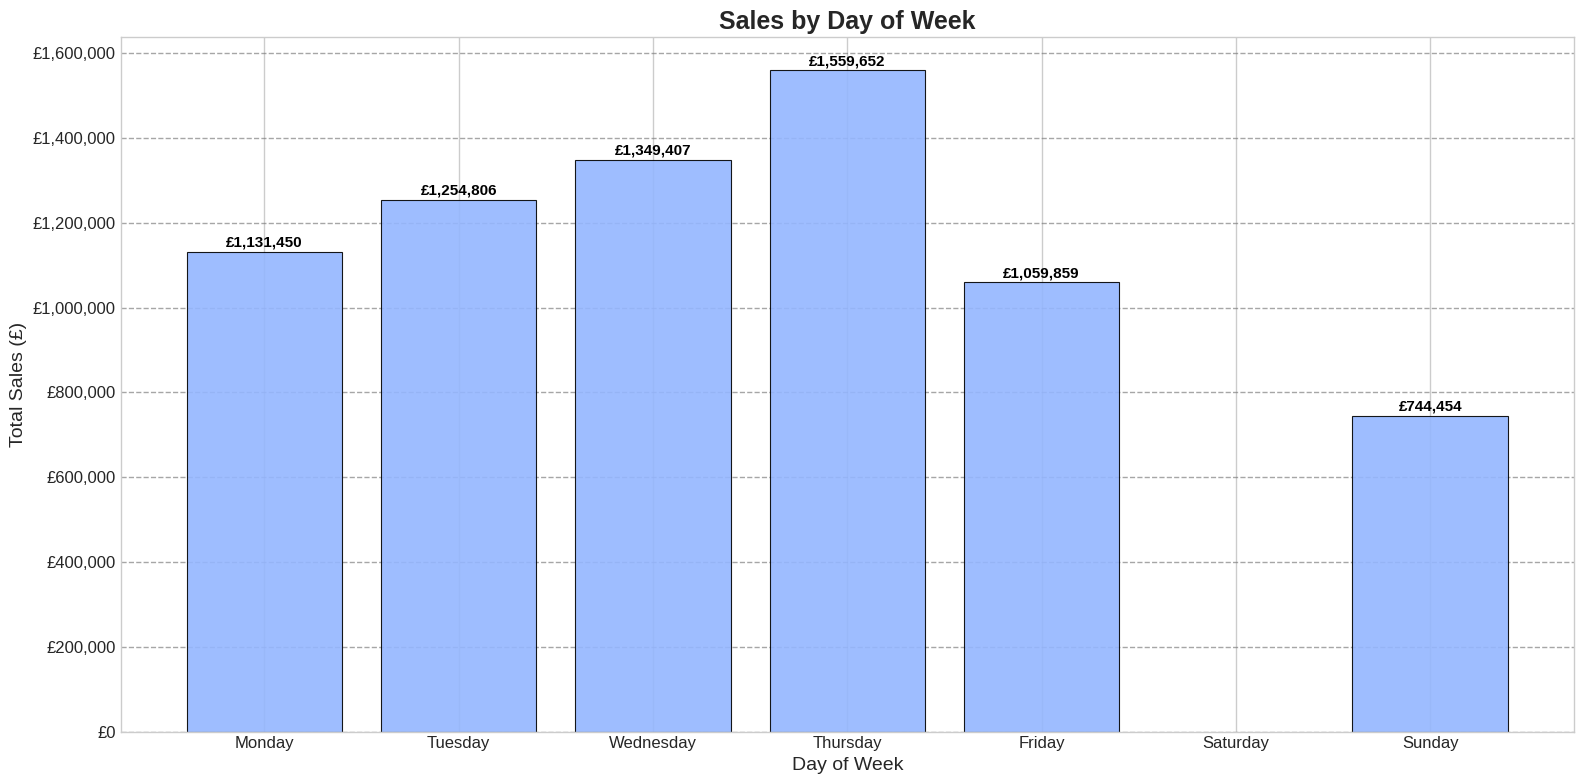

Sales by day of week:


,TotalPrice
Monday,1131450.011
Tuesday,1254806.021
Wednesday,1349406.670
Thursday,1559651.960
Friday,1059858.791
Saturday,NaN
Sunday,744454.331


In [56]:
#------------------------------------
# SALES BY DAY OF WEEK
#------------------------------------
print("\n===== SALES BY DAY OF WEEK =====")

# Define a color palette (example using 'seaborn' color palette)
import seaborn as sns
colors = sns.color_palette("coolwarm", 10)  # You can choose a different color palette if desired

# Grouping sales by the day of the week
weekday_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_sales = df_valid.groupby('InvoiceWeekday')['TotalPrice'].sum().reindex(range(7))
weekday_sales.index = weekday_names

# Create the figure and axis with a larger size for better visibility in a document
fig, ax = plt.subplots(figsize=(16, 8))  # Adjusted for document-friendly output

# Plotting the bar chart with customizations
bars = ax.bar(weekday_sales.index, weekday_sales.values, color=colors[2],  # Now using colors[2] from the seaborn palette
              edgecolor='black', linewidth=0.8, alpha=0.9)

# Adding value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 5000, f'£{height:,.0f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold', color='black')

# Adding the title and labels with customized styling
ax.set_title('Sales by Day of Week', fontsize=18, fontweight='bold')
ax.set_xlabel('Day of Week', fontsize=14)
ax.set_ylabel('Total Sales (£)', fontsize=14)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# Format the y-axis to show currency with commas
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: '£{:,}'.format(int(x))))

# Adding gridlines to make the chart easier to interpret
ax.grid(axis='y', linestyle='--', alpha=0.7, color='gray')

# Tight layout to prevent any overlap
plt.tight_layout()

# Show the plot
plt.show()

# Display the sales by day of the week
print("Sales by day of week:")
display(weekday_sales)



===== TOP 10 SELLING PRODUCTS =====


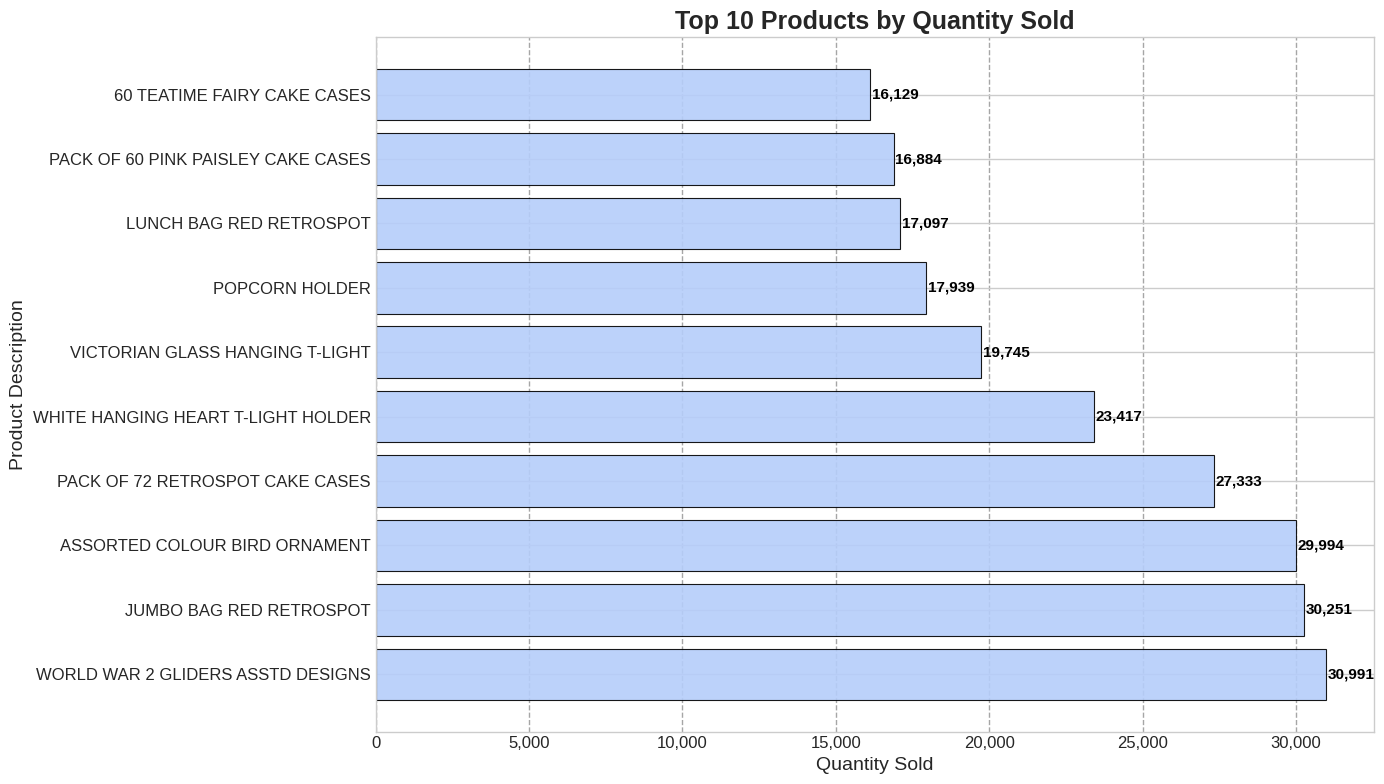

Top selling products:


,Quantity
Description,
WORLD WAR 2 GLIDERS ASSTD DESIGNS,30991
JUMBO BAG RED RETROSPOT,30251
ASSORTED COLOUR BIRD ORNAMENT,29994
PACK OF 72 RETROSPOT CAKE CASES,27333
WHITE HANGING HEART T-LIGHT HOLDER,23417
VICTORIAN GLASS HANGING T-LIGHT,19745
POPCORN HOLDER,17939
LUNCH BAG RED RETROSPOT,17097
PACK OF 60 PINK PAISLEY CAKE CASES,16884


In [59]:
#------------------------------------
# TOP 10 SELLING PRODUCTS
#------------------------------------
print("\n===== TOP 10 SELLING PRODUCTS =====")

# Define a color palette (seaborn or any custom list)
import seaborn as sns
colors = sns.color_palette("coolwarm", 10)  # This ensures color consistency without errors

# Grouping the data by product description and summing quantities
top_products = df_valid.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)

# Create the figure and axis with larger size for better visibility in a report
fig, ax = plt.subplots(figsize=(14, 8))

# Plotting the horizontal bar chart with customizations
bars = ax.barh(top_products.index, top_products.values, color=colors[3],  # Using colors[3] from seaborn
               edgecolor='black', linewidth=0.8, alpha=0.9)

# Add value labels to the bars
for bar in bars:
    width = bar.get_width()
    ax.text(width + 50, bar.get_y() + bar.get_height()/2, f'{width:,.0f}',
            ha='left', va='center', fontsize=11, fontweight='bold', color='black')

# Adding the title and axis labels with customized styling
ax.set_title('Top 10 Products by Quantity Sold', fontsize=18, fontweight='bold')
ax.set_xlabel('Quantity Sold', fontsize=14)
ax.set_ylabel('Product Description', fontsize=14)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# Format the x-axis to display more readable numbers with commas
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: f'{x:,.0f}'))

# Adding gridlines for better readability
ax.grid(axis='x', linestyle='--', alpha=0.7, color='gray')

# Tight layout to ensure nothing is cropped in the plot
plt.tight_layout()

# Show the plot
plt.show()

# Display the top products data
print("Top selling products:")
display(top_products)


In [10]:
# RFM Analysis
print("\n===== RFM ANALYSIS =====")

# Calculate the recency, frequency and monetary value for each customer
# Set the maximum date as the reference point for recency calculation
max_date = df_valid['InvoiceDate'].max() + timedelta(days=1)

# Group by CustomerID and calculate RFM metrics
rfm = df_valid.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (max_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                              # Frequency
    'TotalPrice': 'sum'                                  # Monetary Value
})

# Rename the columns
rfm.columns = ['Recency', 'Frequency', 'Monetary']

# Ensure positive monetary values
rfm = rfm[rfm['Monetary'] > 0]

# Display RFM summary
print("\nRFM Summary Statistics:")
display(rfm.describe())


===== RFM ANALYSIS =====

RFM Summary Statistics:


,Recency,Frequency,Monetary
count,4302.000000,4302.000000,4302.000000
mean,92.569967,4.218271,1650.308643
std,100.111148,7.516827,5155.169116
min,1.000000,1.000000,2.900000
25%,18.000000,1.000000,301.095000
50%,51.000000,2.000000,656.440000
75%,142.000000,5.000000,1591.290000
max,374.000000,207.000000,198860.120000



Customer Segment Distribution:


,count
Segment,
Champions,879
Lost,663
Loyal Customers,561
Potential Loyalists,489
Need Attention,457
At Risk,401
Promising,354
New Customers,298


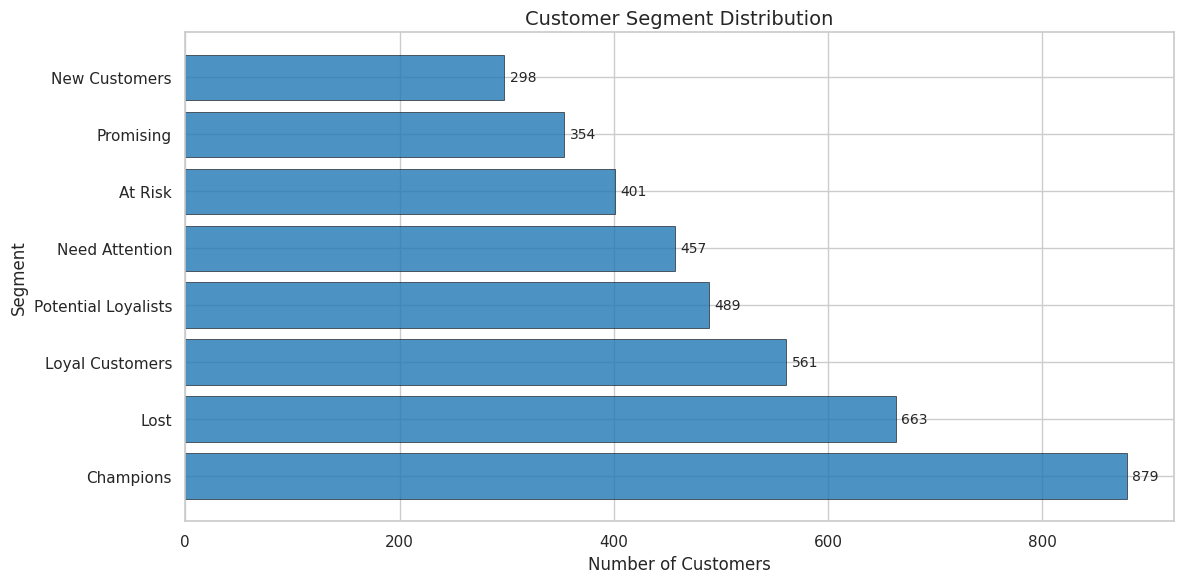


Segment Monetary Value Analysis:


,mean,median,count
Segment,,,
Champions,4930.100796,2633.010,879
Loyal Customers,1801.667649,1344.780,561
Need Attention,1160.916063,814.000,457
Potential Loyalists,772.909284,595.420,489
At Risk,623.400429,429.600,401
Promising,484.971864,337.875,354
New Customers,390.706107,278.675,298
Lost,330.141342,238.850,663


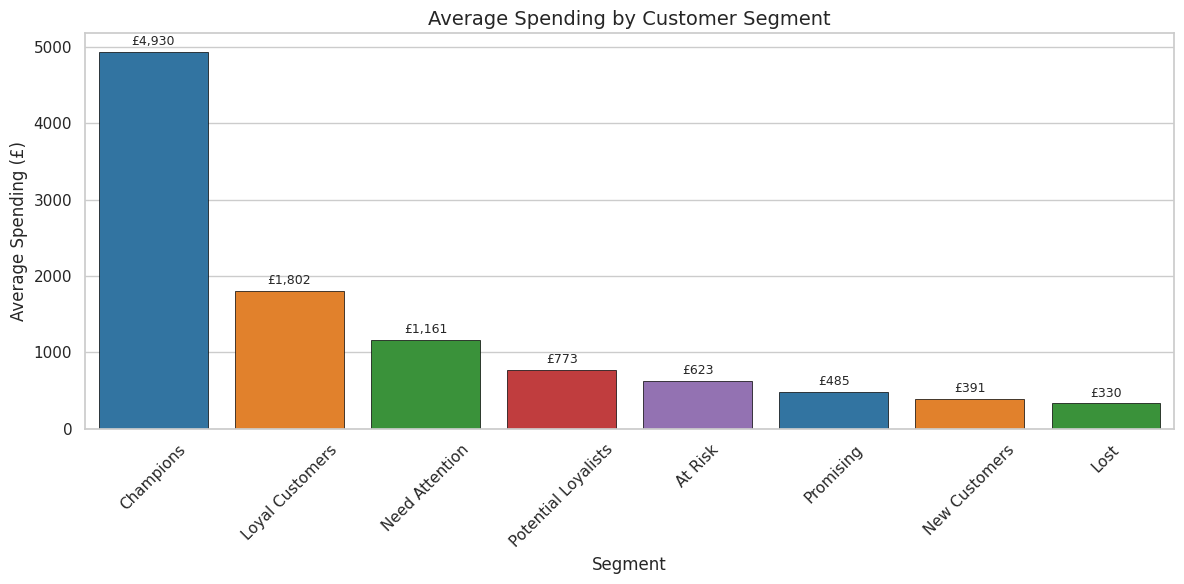

In [61]:
# Constants
FIGSIZE_MEDIUM = (12, 6)
COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  # Example color palette for consistency

def create_rfm_segments(rfm_data):
    """Create RFM segments based on quintiles"""
    quintiles = 5

    # Recency (lower recency is better, so we use qcut with ascending=False)
    rfm_data['R_Score'] = pd.qcut(rfm_data['Recency'], quintiles, labels=range(5, 0, -1), duplicates='drop')

    # Frequency and Monetary (higher is better)
    rfm_data['F_Score'] = pd.qcut(rfm_data['Frequency'].rank(method='first'), quintiles, labels=range(1, 6))
    rfm_data['M_Score'] = pd.qcut(rfm_data['Monetary'].rank(method='first'), quintiles, labels=range(1, 6))

    # Convert scores to numeric
    rfm_data['R_Score'] = rfm_data['R_Score'].astype(int)
    rfm_data['F_Score'] = rfm_data['F_Score'].astype(int)
    rfm_data['M_Score'] = rfm_data['M_Score'].astype(int)

    # Calculate RFM Score (Sum of Recency, Frequency, and Monetary Scores)
    rfm_data['RFM_Score'] = rfm_data['R_Score'] + rfm_data['F_Score'] + rfm_data['M_Score']

    # Create a combined R and F score for segmentation
    rfm_data['RF_Score'] = rfm_data['R_Score'].astype(str) + rfm_data['F_Score'].astype(str)

    return rfm_data

def create_segments(rfm_data):
    """Create customer segments based on R and F scores"""
    segment_map = {
        '55': 'Champions', '54': 'Champions', '45': 'Champions',
        '44': 'Loyal Customers', '35': 'Loyal Customers', '34': 'Loyal Customers',
        '33': 'Potential Loyalists', '43': 'Potential Loyalists', '53': 'Potential Loyalists',
        '52': 'Promising', '42': 'Promising', '32': 'Promising',
        '41': 'New Customers', '31': 'New Customers', '51': 'New Customers',
        '25': 'Need Attention', '24': 'Need Attention', '23': 'Need Attention',
        '22': 'At Risk', '15': 'At Risk', '14': 'At Risk', '13': 'At Risk',
        '12': 'Lost', '11': 'Lost'
    }
    rfm_data['Segment'] = rfm_data['RF_Score'].map(segment_map)
    return rfm_data

# Apply the RFM segmentation and assign customer segments
rfm = create_rfm_segments(rfm)
rfm = create_segments(rfm)

# Display the distribution of customer segments
print("\nCustomer Segment Distribution:")
segment_counts = rfm['Segment'].value_counts()
display(segment_counts)

# Plot the segment distribution with bar chart
fig, ax = plt.subplots(figsize=FIGSIZE_MEDIUM)
bars = ax.barh(segment_counts.index, segment_counts.values, color=COLORS[0], alpha=0.8, edgecolor='black', linewidth=0.5)

# Add value labels to the bars
for bar in bars:
    width = bar.get_width()
    ax.text(width + 5, bar.get_y() + bar.get_height() / 2,
            f'{width:,.0f}', ha='left', va='center', fontsize=10)

# Customize the plot
ax.set_title('Customer Segment Distribution', fontsize=14)
ax.set_xlabel('Number of Customers', fontsize=12)
ax.set_ylabel('Segment', fontsize=12)
plt.tight_layout()
plt.show()

# Analyze the monetary value of each segment
segment_monetary = rfm.groupby('Segment')['Monetary'].agg(['mean', 'median', 'count']).sort_values('mean', ascending=False)
print("\nSegment Monetary Value Analysis:")
display(segment_monetary)

# Plot average spending by customer segment
fig, ax = plt.subplots(figsize=FIGSIZE_MEDIUM)
sns.barplot(x=segment_monetary.index, y=segment_monetary['mean'], palette=COLORS, ax=ax, edgecolor='black', linewidth=0.5)

# Add monetary value labels
for i, bar in enumerate(ax.patches):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2., height + 50,
            f'£{height:,.0f}', ha='center', va='bottom', fontsize=9)

# Customize the plot
ax.set_title('Average Spending by Customer Segment', fontsize=14)
ax.set_xlabel('Segment', fontsize=12)
ax.set_ylabel('Average Spending (£)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


===== K-MEANS CLUSTERING FOR CUSTOMER SEGMENTATION =====
For n_clusters = 2, the silhouette score is 0.902
For n_clusters = 3, the silhouette score is 0.576
For n_clusters = 4, the silhouette score is 0.605
For n_clusters = 5, the silhouette score is 0.595
For n_clusters = 6, the silhouette score is 0.500
For n_clusters = 7, the silhouette score is 0.500
For n_clusters = 8, the silhouette score is 0.492
For n_clusters = 9, the silhouette score is 0.480
For n_clusters = 10, the silhouette score is 0.484

Optimal number of clusters: 2


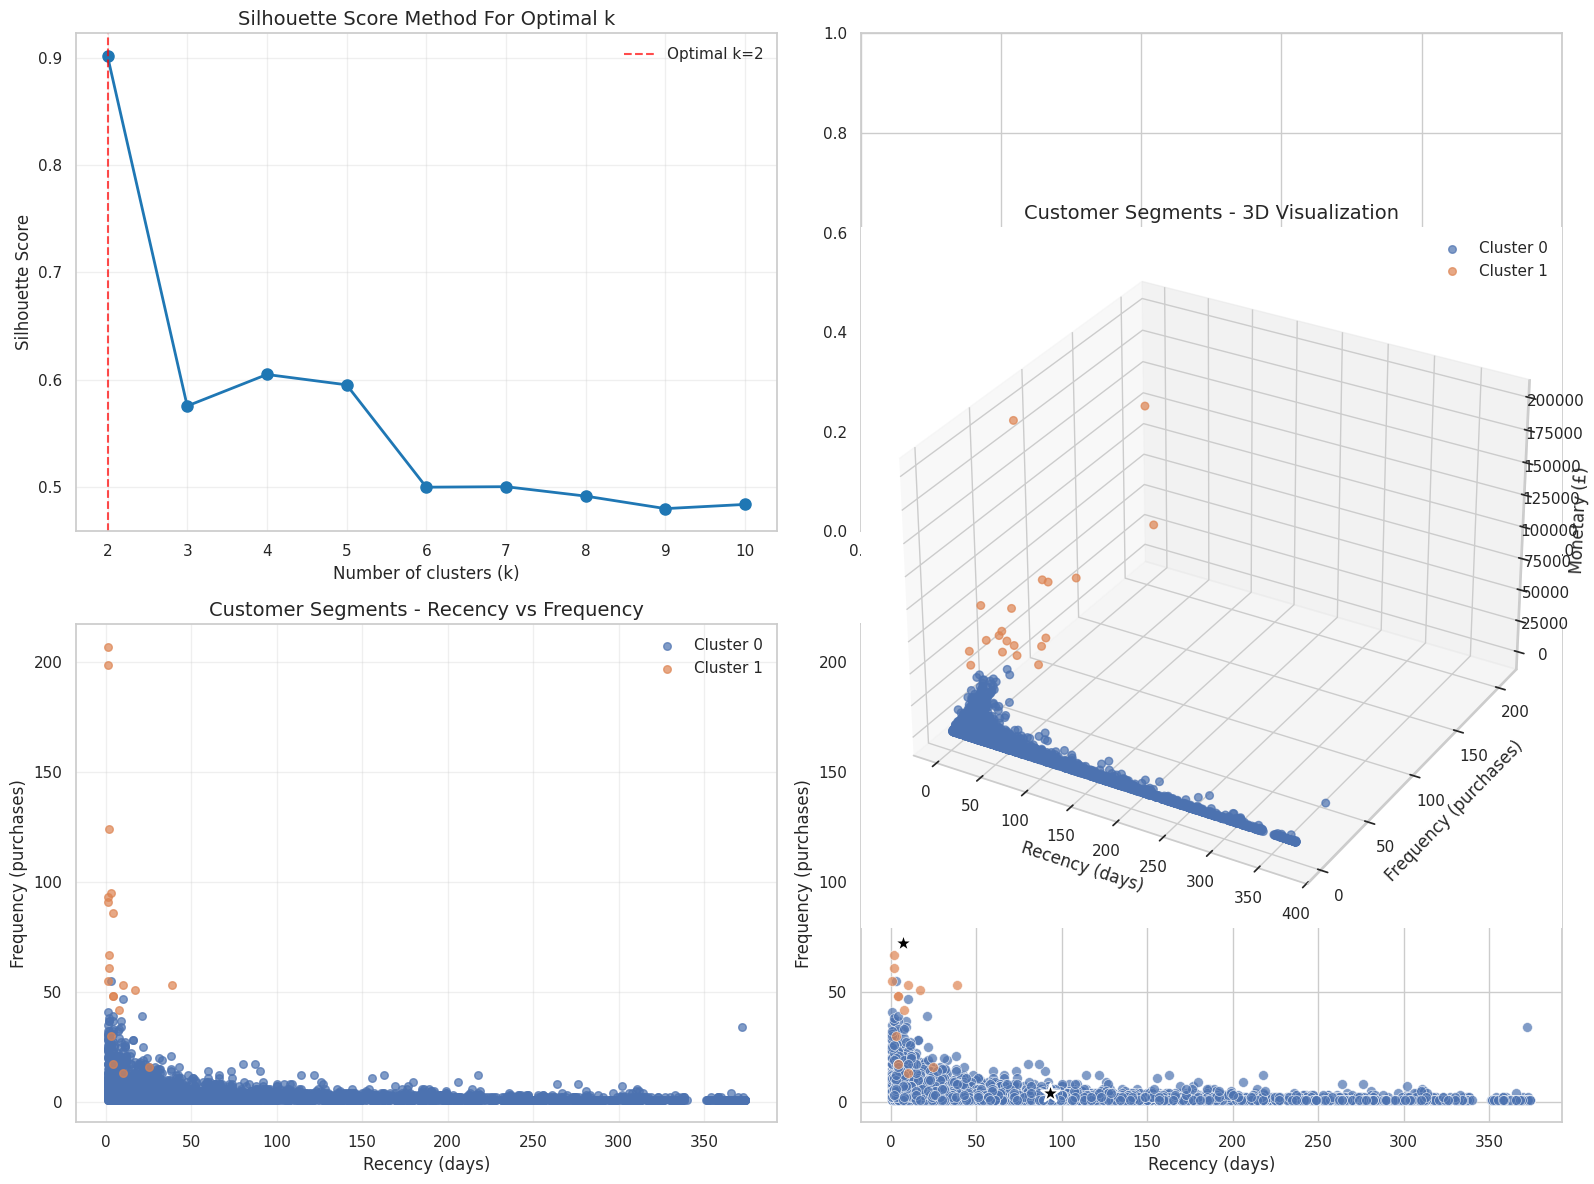


Cluster Analysis:


,Recency,Frequency,Monetary,Count
Cluster,,,,
0,92.969173,3.89958,1400.379363,4282
1,7.100000,72.45000,55160.167500,20


In [62]:
#------------------------------------
# K-MEANS CLUSTERING FOR CUSTOMER SEGMENTATION
#------------------------------------
print("\n===== K-MEANS CLUSTERING FOR CUSTOMER SEGMENTATION =====")

# Prepare data for clustering - Scale the RFM values
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# Find optimal number of clusters using silhouette score
silhouette_scores = []
range_n_clusters = range(2, 11)
for n_clusters in range_n_clusters:
    # Initialize the clusterer
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, max_iter=300, random_state=42)
    cluster_labels = kmeans.fit_predict(rfm_scaled)

    # Calculate silhouette score
    silhouette_avg = silhouette_score(rfm_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {n_clusters}, the silhouette score is {silhouette_avg:.3f}")

# Choose optimal number of clusters based on silhouette score
optimal_k = range_n_clusters[silhouette_scores.index(max(silhouette_scores))]
print(f"\nOptimal number of clusters: {optimal_k}")

# Apply K-means clustering with optimal k
kmeans = KMeans(n_clusters=optimal_k, n_init=10, max_iter=300, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Analyze clusters
rfm_with_id = rfm.reset_index()
cluster_analysis = rfm_with_id.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'Count'})

# Create subplots to display results side by side
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot silhouette scores for optimal k
axes[0, 0].plot(range_n_clusters, silhouette_scores, marker='o', linestyle='-', color=COLORS[0], linewidth=2, markersize=8)
axes[0, 0].set_title('Silhouette Score Method For Optimal k', fontsize=14)
axes[0, 0].set_xlabel('Number of clusters (k)', fontsize=12)
axes[0, 0].set_ylabel('Silhouette Score', fontsize=12)
axes[0, 0].axvline(x=optimal_k, color='red', linestyle='--', alpha=0.7, label=f'Optimal k={optimal_k}')
axes[0, 0].legend(loc='best')
axes[0, 0].grid(True, alpha=0.3)

# Plot 3D scatter plot for customer segmentation
ax_3d = fig.add_subplot(122, projection='3d')
for cluster in range(optimal_k):
    cluster_data = rfm[rfm['Cluster'] == cluster]
    ax_3d.scatter(cluster_data['Recency'],
                  cluster_data['Frequency'],
                  cluster_data['Monetary'],
                  s=30,
                  label=f'Cluster {cluster}',
                  alpha=0.7)
ax_3d.set_xlabel('Recency (days)', fontsize=12)
ax_3d.set_ylabel('Frequency (purchases)', fontsize=12)
ax_3d.set_zlabel('Monetary (£)', fontsize=12)
ax_3d.set_title('Customer Segments - 3D Visualization', fontsize=14)
ax_3d.legend()

# 2D visualization (Recency vs Frequency)
for cluster in range(optimal_k):
    cluster_data = rfm[rfm['Cluster'] == cluster]
    axes[1, 0].scatter(cluster_data['Recency'],
                       cluster_data['Frequency'],
                       s=30,
                       label=f'Cluster {cluster}',
                       alpha=0.7)
axes[1, 0].set_xlabel('Recency (days)', fontsize=12)
axes[1, 0].set_ylabel('Frequency (purchases)', fontsize=12)
axes[1, 0].set_title('Customer Segments - Recency vs Frequency', fontsize=14)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 2D visualization with Cluster Centers
axes[1, 1].set_title('Customer Segments - Recency vs Frequency (with Centers)', fontsize=14)
for cluster in range(optimal_k):
    cluster_data = rfm[rfm['Cluster'] == cluster]
    axes[1, 1].scatter(cluster_data['Recency'],
                       cluster_data['Frequency'],
                       s=50,
                       label=f'Cluster {cluster}',
                       alpha=0.7,
                       edgecolors='w',
                       linewidth=0.5)

# Add cluster centers
centers = scaler.inverse_transform(kmeans.cluster_centers_)
for i, center in enumerate(centers):
    axes[1, 1].scatter(center[0], center[1], s=200, marker='*',
                       color='black', edgecolors='w', linewidth=1.5,
                       label='Cluster Centers' if i == 0 else "")

axes[1, 1].set_xlabel('Recency (days)', fontsize=12)
axes[1, 1].set_ylabel('Frequency (purchases)', fontsize=12)
axes[1, 1].legend(title='Clusters')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

# Print Cluster Analysis Summary
print("\nCluster Analysis:")
display(cluster_analysis)



===== MARKET BASKET ANALYSIS =====
Finding frequent itemsets...
Generating association rules...
Number of association rules found: 76

Top 10 association rules by lift:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
71,"(PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",(GREEN REGENCY TEACUP AND SAUCER),0.023861,0.037968,0.021381,0.896074,23.600948,1.0,0.020475,9.256888,0.981037,0.528610,0.891972,0.729604
74,(GREEN REGENCY TEACUP AND SAUCER),"(PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",0.037968,0.023861,0.021381,0.563135,23.600948,1.0,0.020475,2.234419,0.995423,0.528610,0.552456,0.729604
72,"(GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC...",(PINK REGENCY TEACUP AND SAUCER),0.029702,0.030528,0.021381,0.719852,23.579687,1.0,0.020474,3.460564,0.986904,0.550355,0.711030,0.710106
73,(PINK REGENCY TEACUP AND SAUCER),"(GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC...",0.030528,0.029702,0.021381,0.700361,23.579687,1.0,0.020474,3.238224,0.987745,0.550355,0.691189,0.710106
8,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.030528,0.037968,0.025293,0.828520,21.821698,1.0,0.024134,5.610167,0.984221,0.585459,0.821752,0.747351
9,(GREEN REGENCY TEACUP AND SAUCER),(PINK REGENCY TEACUP AND SAUCER),0.037968,0.030528,0.025293,0.666183,21.821698,1.0,0.024134,2.904200,0.991832,0.585459,0.655671,0.747351
70,"(PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...",(ROSES REGENCY TEACUP AND SAUCER ),0.025293,0.042762,0.021381,0.845316,19.767974,1.0,0.020299,6.188342,0.974050,0.458087,0.838406,0.672658
75,(ROSES REGENCY TEACUP AND SAUCER ),"(PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...",0.042762,0.025293,0.021381,0.500000,19.767974,1.0,0.020299,1.949413,0.991825,0.458087,0.487025,0.672658
10,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER ),0.037968,0.042762,0.029702,0.782293,18.294168,1.0,0.028078,4.396914,0.982647,0.582073,0.772568,0.738440
11,(ROSES REGENCY TEACUP AND SAUCER ),(GREEN REGENCY TEACUP AND SAUCER),0.042762,0.037968,0.029702,0.694588,18.294168,1.0,0.028078,3.149945,0.987568,0.582073,0.682534,0.738440


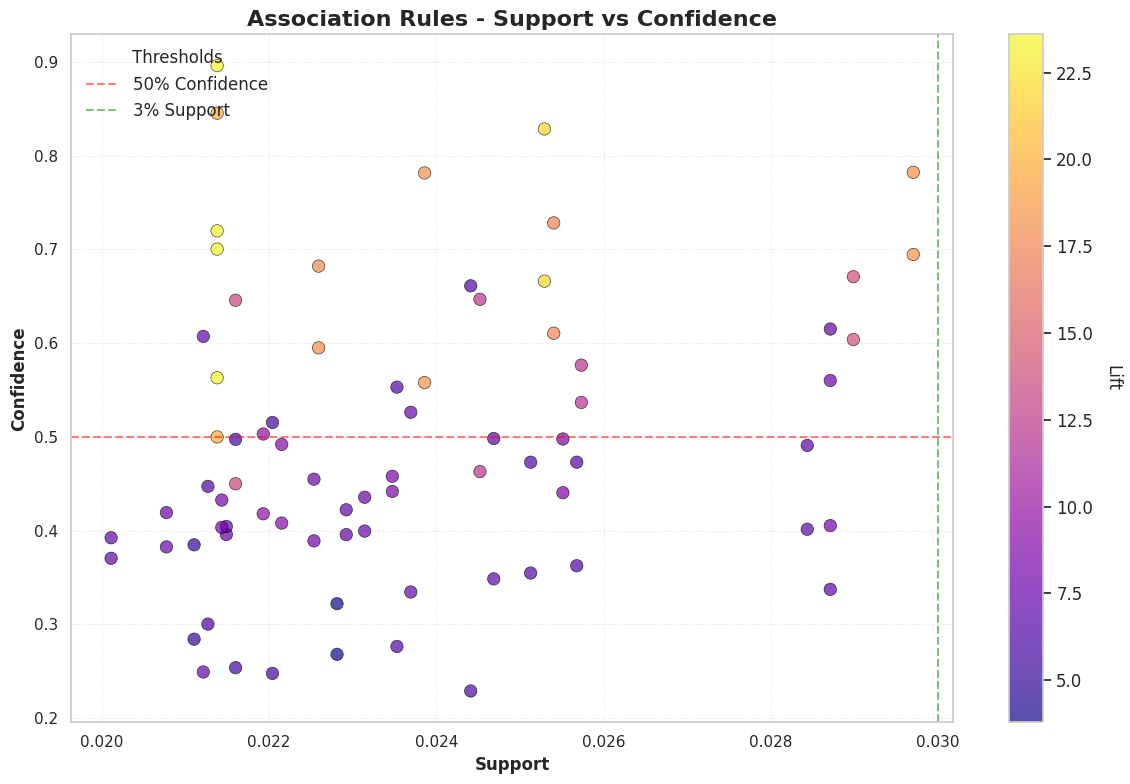

In [69]:
# Define font size constants for better readability
LABEL_FONTSIZE = 12  # Font size for labels
TITLE_FONTSIZE = 16  # Font size for title

#------------------------------------
# MARKET BASKET ANALYSIS
#------------------------------------
print("\n===== MARKET BASKET ANALYSIS =====")

# Prepare data for market basket analysis
# Create a basket for each invoice
baskets = df_valid.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().reset_index()
basket_sets = baskets.pivot_table(index='InvoiceNo', columns='Description', values='Quantity', fill_value=0)

# Convert quantity to binary (bought or not bought)
basket_sets_binary = basket_sets.applymap(lambda x: 1 if x > 0 else 0)

# Find frequent itemsets
print("Finding frequent itemsets...")
frequent_itemsets = apriori(basket_sets_binary, min_support=0.02, use_colnames=True)

# Generate association rules
print("Generating association rules...")
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# Output the number of rules and display the top 10 by lift
print(f"Number of association rules found: {len(rules):,}")
top_10_rules = rules.sort_values('lift', ascending=False).head(10)
print("\nTop 10 association rules by lift:")
display(top_10_rules)

# Enhanced Visualization of Association Rules
fig, ax = plt.subplots(figsize=(12, 8))

# Create a scatter plot with customized styling
scatter = ax.scatter(rules['support'], rules['confidence'],
                     alpha=0.7, s=80, c=rules['lift'],
                     cmap='plasma', edgecolors='black', linewidth=0.5, marker='o')

# Add colorbar for lift values with label rotation
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Lift', rotation=270, labelpad=20, fontsize=LABEL_FONTSIZE)
cbar.ax.tick_params(labelsize=LABEL_FONTSIZE)

# Add reference lines for 50% Confidence and 5% Support
ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='50% Confidence', linewidth=1.5)
ax.axvline(x=0.03, color='green', linestyle='--', alpha=0.5, label='3% Support', linewidth=1.5)

# Set axis labels with font size
ax.set_xlabel('Support', fontsize=LABEL_FONTSIZE, fontweight='semibold')
ax.set_ylabel('Confidence', fontsize=LABEL_FONTSIZE, fontweight='semibold')

# Set title with bold font and larger size
ax.set_title('Association Rules - Support vs Confidence', fontsize=TITLE_FONTSIZE, fontweight='bold')

# Add a grid with transparency for better readability
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.7)

# Add legend with a title and custom font size, only including the threshold lines
ax.legend(loc='upper left', fontsize=LABEL_FONTSIZE, title='Thresholds', title_fontsize=LABEL_FONTSIZE)

# Tight layout for better spacing
plt.tight_layout()

# Show plot
plt.show()



===== GEOGRAPHIC ANALYSIS =====


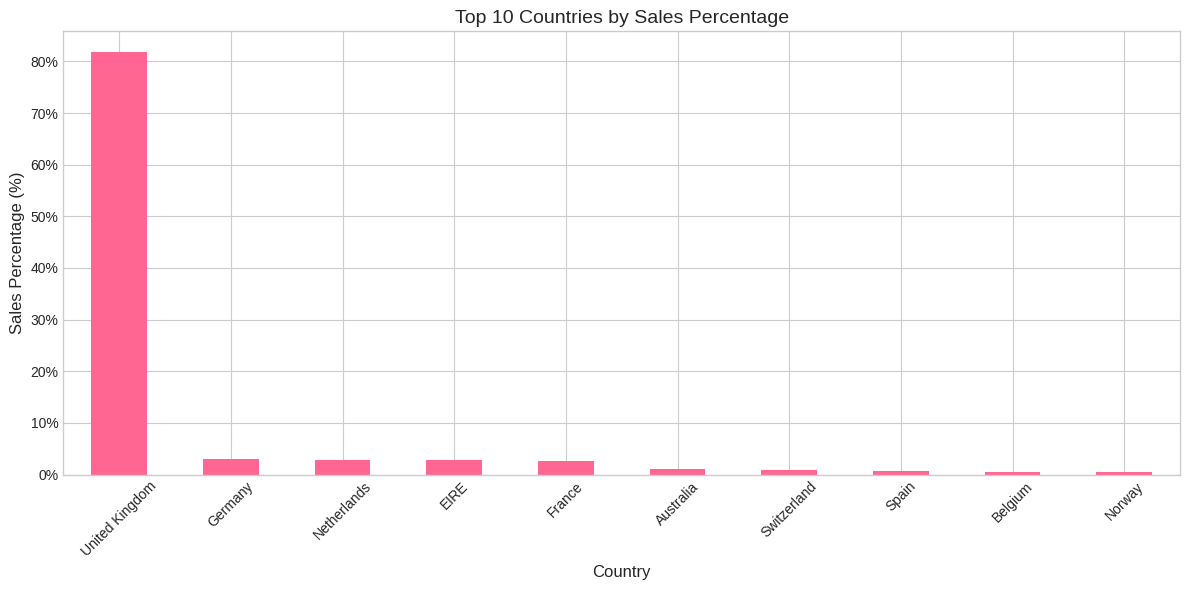

Country sales percentage:


,TotalPrice
Country,
United Kingdom,81.752405
Germany,3.035583
Netherlands,2.874805
EIRE,2.836972
France,2.676546
Australia,1.118579
Switzerland,0.777279
Spain,0.714236
Belgium,0.580261


<Figure size 1400x800 with 0 Axes>

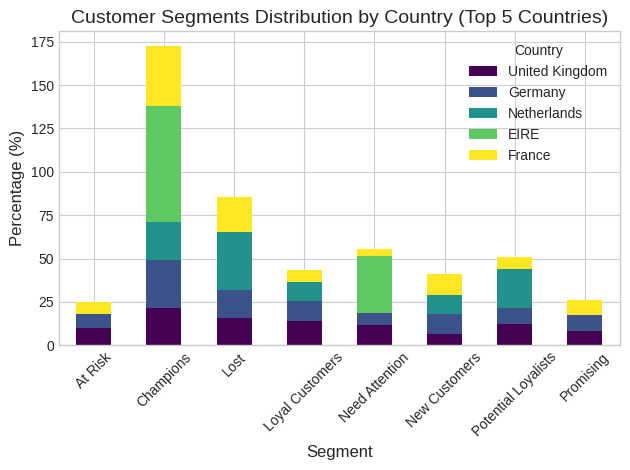

Customer segments by country (percentages):


Country,United Kingdom,Germany,Netherlands,EIRE,France
Segment,,,,,
At Risk,9.798116,8.045977,0.000000,0.000000,7.142857
Champions,21.399731,27.586207,22.222222,66.666667,34.523810
Lost,15.773890,16.091954,33.333333,0.000000,20.238095
Loyal Customers,13.943472,11.494253,11.111111,0.000000,7.142857
Need Attention,11.520861,6.896552,0.000000,33.333333,3.571429
New Customers,6.621803,11.494253,11.111111,0.000000,11.904762
Potential Loyalists,12.489906,9.195402,22.222222,0.000000,7.142857
Promising,8.452221,9.195402,0.000000,0.000000,8.333333



===== ANALYSIS COMPLETE =====
All visualizations have been displayed in Colab.
The analysis revealed several distinct customer segments and purchase patterns that can inform marketing strategies.


In [14]:
# Geographic analysis
print("\n===== GEOGRAPHIC ANALYSIS =====")

# Sales by country
country_sales = df_valid.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False)
total_sales = country_sales.sum()
country_pct = country_sales / total_sales * 100

plt.figure(figsize=(12, 6))
country_pct.head(10).plot(kind='bar', color=colors[6])
plt.title('Top 10 Countries by Sales Percentage', fontsize=14)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Sales Percentage (%)', fontsize=12)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
print("Country sales percentage:")
display(country_pct.head(10))

# Customer segmentation by country
country_segments = pd.crosstab(rfm['Segment'], df_valid.groupby('CustomerID')['Country'].first())
country_segments_pct = country_segments.div(country_segments.sum(), axis=1) * 100

# Select top 5 countries for visualization clarity
top_countries = country_sales.head(5).index.tolist()
plt.figure(figsize=(14, 8))
country_segments_pct[top_countries].plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Customer Segments Distribution by Country (Top 5 Countries)', fontsize=14)
plt.xlabel('Segment', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.legend(title='Country')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
print("Customer segments by country (percentages):")
display(country_segments_pct[top_countries])

print("\n===== ANALYSIS COMPLETE =====")
print("All visualizations have been displayed in Colab.")
print("The analysis revealed several distinct customer segments and purchase patterns that can inform marketing strategies.")


===== GEOGRAPHIC ANALYSIS =====


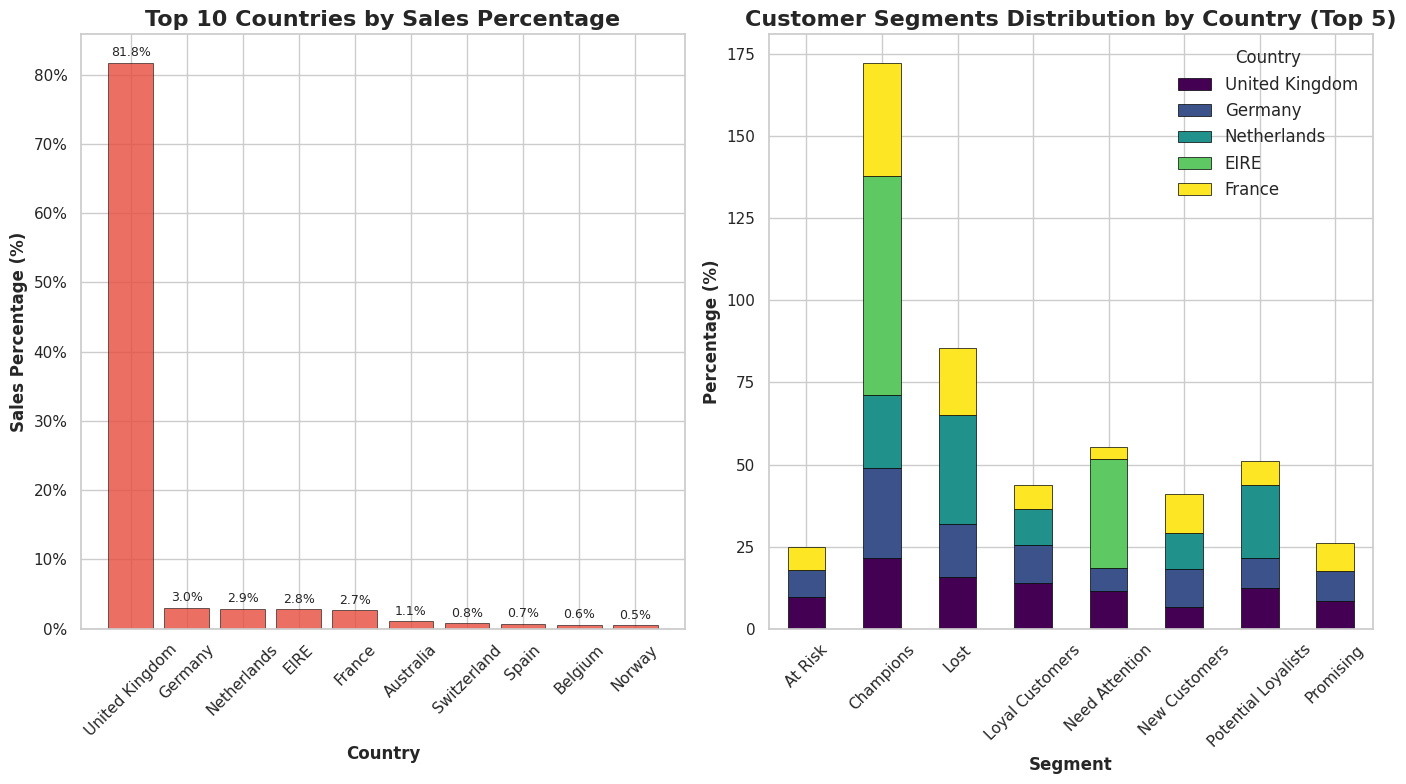

Country sales percentage:


,TotalPrice
Country,
United Kingdom,81.752405
Germany,3.035583
Netherlands,2.874805
EIRE,2.836972
France,2.676546
Australia,1.118579
Switzerland,0.777279
Spain,0.714236
Belgium,0.580261


Customer segments by country (percentages):


Country,United Kingdom,Germany,Netherlands,EIRE,France
Segment,,,,,
At Risk,9.798116,8.045977,0.000000,0.000000,7.142857
Champions,21.399731,27.586207,22.222222,66.666667,34.523810
Lost,15.773890,16.091954,33.333333,0.000000,20.238095
Loyal Customers,13.943472,11.494253,11.111111,0.000000,7.142857
Need Attention,11.520861,6.896552,0.000000,33.333333,3.571429
New Customers,6.621803,11.494253,11.111111,0.000000,11.904762
Potential Loyalists,12.489906,9.195402,22.222222,0.000000,7.142857
Promising,8.452221,9.195402,0.000000,0.000000,8.333333



===== ANALYSIS COMPLETE =====
Both plots have been displayed side by side with enhanced styling.
This comparison can help better understand sales patterns and customer distribution.


In [71]:
# Define constants for better readability
LABEL_FONTSIZE = 12  # Font size for labels
TITLE_FONTSIZE = 16  # Font size for title
FIGSIZE_LARGE = (14, 8)  # Large figure size
COLORS = ['#FF5733', '#33FF57', '#3357FF', '#F1C40F', '#9B59B6', '#1ABC9C', '#E74C3C']  # Custom colors for plots

#------------------------------------
# GEOGRAPHIC ANALYSIS (Side-by-side Plots)
#------------------------------------
print("\n===== GEOGRAPHIC ANALYSIS =====")

# Sales by country
country_sales = df_valid.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False)
total_sales = country_sales.sum()
country_pct = country_sales / total_sales * 100

# Customer segmentation by country
country_segments = pd.crosstab(rfm['Segment'], df_valid.groupby('CustomerID')['Country'].first())
country_segments_pct = country_segments.div(country_segments.sum(), axis=1) * 100

# Select top 5 countries for segmentation visualization
top_countries = country_sales.head(5).index.tolist()

# Create a figure with two subplots: one for Sales and one for Segmentation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=FIGSIZE_LARGE)

# Plot 1: Sales by Country (Top 10)
bars = ax1.bar(country_pct.head(10).index, country_pct.head(10).values,
             color=COLORS[6], edgecolor='black', linewidth=0.5, alpha=0.8)

# Add percentage labels on the bars in the first plot
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

ax1.yaxis.set_major_formatter(mtick.PercentFormatter())
ax1.set_xlabel('Country', fontsize=LABEL_FONTSIZE, fontweight='semibold')
ax1.set_ylabel('Sales Percentage (%)', fontsize=LABEL_FONTSIZE, fontweight='semibold')
ax1.set_title('Top 10 Countries by Sales Percentage', fontsize=TITLE_FONTSIZE, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)

# Plot 2: Customer Segments Distribution by Country (Top 5 Countries)
country_segments_pct[top_countries].plot(kind='bar', stacked=True, colormap='viridis', ax=ax2,
                                          edgecolor='black', linewidth=0.5)

ax2.set_xlabel('Segment', fontsize=LABEL_FONTSIZE, fontweight='semibold')
ax2.set_ylabel('Percentage (%)', fontsize=LABEL_FONTSIZE, fontweight='semibold')
ax2.set_title('Customer Segments Distribution by Country (Top 5)', fontsize=TITLE_FONTSIZE, fontweight='bold')
ax2.legend(title='Country', fontsize=LABEL_FONTSIZE, title_fontsize=LABEL_FONTSIZE)
ax2.tick_params(axis='x', rotation=45)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots side by side
plt.show()

# Display sales percentage for top countries
print("Country sales percentage:")
display(country_pct.head(10))

# Display customer segment percentages for top countries
print("Customer segments by country (percentages):")
display(country_segments_pct[top_countries])

print("\n===== ANALYSIS COMPLETE =====")
print("Both plots have been displayed side by side with enhanced styling.")
print("This comparison can help better understand sales patterns and customer distribution.")


In [73]:
#------------------------------------
# INTERACTIVE INSIGHT Q&A SECTION WITH SAMPLE PROMPTS
#------------------------------------
print("\n===== INSIGHT Q&A MODULE =====")

from IPython.display import display, Markdown

# Sample question suggestions
sample_questions = [
    "Top products",
    "Items frequently bought together",
    "Sales by country",
    "Top products bought by Champions",
    "Customer segments by country"
]

# Show sample question list
print("💬 Try asking me things like:")
for i, q in enumerate(sample_questions, 1):
    print(f"  {i}. {q}")

def ask_question(q):
    q = q.lower()

    if 'top products' in q:
        top_products = df_valid.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
        print("\n📦 Top 10 Best-Selling Products:")
        return top_products

    elif 'bought together' in q or 'frequent pairs' in q:
        top_rules = rules.sort_values('lift', ascending=False)[['antecedents', 'consequents', 'lift']].head(5)
        print("\n🛒 Top 5 Product Combinations (by Lift):")
        return top_rules

    elif 'sales by country' in q or 'top countries' in q:
        print("\n🌍 Top 10 Countries by Sales Percentage:")
        return country_pct.head(10)

    elif 'champions' in q and 'products' in q:
        champ_ids = rfm[rfm['Segment'] == 'Champions'].index
        champ_data = df_valid[df_valid['CustomerID'].isin(champ_ids)]
        top_champ_products = champ_data.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
        print("\n🏆 Top Products Purchased by 'Champions':")
        return top_champ_products

    elif 'country segments' in q or 'customer segments by country' in q:
        country_segments = pd.crosstab(rfm['Segment'], df_valid.groupby('CustomerID')['Country'].first())
        country_segments_pct = country_segments.div(country_segments.sum(), axis=1) * 100
        top_countries = country_pct.head(5).index.tolist()
        print("\n📊 Customer Segment Distribution for Top 5 Countries:")
        return country_segments_pct[top_countries]

    else:
        return "❓ I didn't understand. Try asking:\n" + \
               "\n".join([f"- {s}" for s in sample_questions])

# Ask once via input box
q = input("\n🔎 Ask a question about the data: ")
result = ask_question(q)
if isinstance(result, pd.Series) or isinstance(result, pd.DataFrame):
    display(result)
else:
    print(result)



===== INSIGHT Q&A MODULE =====
💬 Try asking me things like:
  1. Top products
  2. Items frequently bought together
  3. Sales by country
  4. Top products bought by Champions
  5. Customer segments by country

🔎 Ask a question about the data: Customer segments by country

📊 Customer Segment Distribution for Top 5 Countries:


Country,United Kingdom,Germany,Netherlands,EIRE,France
Segment,,,,,
At Risk,9.798116,8.045977,0.000000,0.000000,7.142857
Champions,21.399731,27.586207,22.222222,66.666667,34.523810
Lost,15.773890,16.091954,33.333333,0.000000,20.238095
Loyal Customers,13.943472,11.494253,11.111111,0.000000,7.142857
Need Attention,11.520861,6.896552,0.000000,33.333333,3.571429
New Customers,6.621803,11.494253,11.111111,0.000000,11.904762
Potential Loyalists,12.489906,9.195402,22.222222,0.000000,7.142857
Promising,8.452221,9.195402,0.000000,0.000000,8.333333
